## Deep learning model: autoencoder

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read in single cell RNA seq data

In [3]:
# load true labels of cells generated from Seurat package
label_data = pd.read_csv("/Users/zhudifei/Desktop/qbio460_final_project/cell_labels.csv")
print(label_data)

                    Cell  Cluster
0     AAACCCATCATCGCAA-1        3
1     AAACGCTGTAATCAAG-1        0
2     AAAGAACCACAAGTGG-1        0
3     AAAGAACCATGAATCC-1        0
4     AAAGAACTCCACATAG-1        0
...                  ...      ...
1995  TTTGGAGGTCGGCTAC-1        0
1996  TTTGGTTGTCCTTTGC-1        0
1997  TTTGGTTTCATATGGC-1        0
1998  TTTGTTGTCACTGTTT-1        4
1999  TTTGTTGTCGCCGAAC-1        0

[2000 rows x 2 columns]


In [4]:
# load data
file = "/Users/zhudifei/Desktop/qbio460_final_project/subset_calcrpos_matrix.csv"
matrix = pd.read_csv(file, index_col=0)
#print(matrix, matrix.shape)

# transpose data into rows represent cells and columns represent genes
sc_data = matrix.T
print(sc_data)

                    LOC134295191  LOC134295088      ctsh     cd79a  \
AAACCCATCATCGCAA-1     -0.418257     -0.253938 -0.389917 -0.031629   
AAACGCTGTAATCAAG-1     -0.418257     -0.253938 -0.389917 -0.031629   
AAAGAACCACAAGTGG-1     -0.418257     -0.253938 -0.389917 -0.031629   
AAAGAACCATGAATCC-1     -0.418257     -0.253938  2.055642 -0.031629   
AAAGAACTCCACATAG-1     -0.418257     -0.253938 -0.389917 -0.031629   
...                          ...           ...       ...       ...   
TTTGGAGGTCGGCTAC-1     -0.418257     -0.253938 -0.389917 -0.031629   
TTTGGTTGTCCTTTGC-1      2.061663     -0.253938 -0.389917 -0.031629   
TTTGGTTTCATATGGC-1     -0.418257     -0.253938 -0.389917 -0.031629   
TTTGTTGTCACTGTTT-1     -0.418257     -0.253938 -0.389917 -0.031629   
TTTGTTGTCGCCGAAC-1     -0.418257     -0.253938  3.073969 -0.031629   

                    LOC100563644      gng2    vstm2b  LOC100565406  \
AAACCCATCATCGCAA-1     -0.231381 -0.225455 -0.043001     -0.286023   
AAACGCTGTAATCAAG-1 

## import and install packages

In [5]:
from sklearn.decomposition import PCA
import umap
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

In [7]:
import time # to track model run time
import tensorflow as tf
import keras
import random

In [8]:
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

### split data into train and test

In [9]:
X_train, X_test = train_test_split(sc_data, test_size=0.2, random_state=42)

### build an autoencoder model

In [10]:
# build the autoencoder model
autoencoder_1 = keras.Sequential()

# input layer
input_layer = keras.Input(shape=(2000,), name="input_layer")

# Encoder layers
## functional API: connect layers explicitly by passing the output of one layer as the input to the next layer
encoder1 = keras.layers.Dense(2048, activation="relu", name="encoder1")(input_layer)
dropout1 = keras.layers.Dropout(0.25)(encoder1)
encoder2 = keras.layers.Dense(512, activation="relu", name="encoder2")(dropout1)
dropout2 = keras.layers.Dropout(0.25)(encoder2)
encoder3 = keras.layers.Dense(256, activation="relu", name="encoder3")(dropout2)
dropout3 = keras.layers.Dropout(0.25)(encoder3)
latent_layer = keras.layers.Dense(50, activation="relu", name="latent")(dropout3)

# Decoder layers
decoder1 = keras.layers.Dense(256, activation="relu", name="decoder1")(latent_layer)
dropout4 = keras.layers.Dropout(0.25)(decoder1)
decoder2 = keras.layers.Dense(512, activation="relu", name="decoder2")(dropout4)
dropout5 = keras.layers.Dropout(0.25)(decoder2)
decoder3 = keras.layers.Dense(2048, activation="relu", name="decoder3")(dropout5)
dropout6 = keras.layers.Dropout(0.25)(decoder3)
output_layer = keras.layers.Dense(2000, activation="linear", name="out_layer")(dropout6)

# Full autoencoder model
autoencoder_1 = keras.Model(inputs=input_layer, outputs=output_layer, name="autoencoder")

# compile the model
autoencoder_1.compile(loss='mse', optimizer='Adam')
autoencoder_1.summary()

# Train the model
history = autoencoder_1.fit(X_train, X_train, validation_data=(X_test, X_test), batch_size=64, epochs=100)


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder1 (Dense)                │ (None, 2048)           │     4,098,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder2 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder3 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 50)             │        12,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder1 (Dense)                │ (None, 256)            │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder2 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder3 (Dense)                │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 2000)           │     4,098,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,584,578 (40.38 MB)

 Trainable params: 10,584,578 (40.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7449 - val_loss: 0.6810
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7104 - val_loss: 0.6738
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6899 - val_loss: 0.6419
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6745 - val_loss: 0.6266
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6674 - val_loss: 0.6157
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6616 - val_loss: 0.6315
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6643 - val_loss: 0.6253
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6547 - val_loss: 0.6214
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6513 - val_loss: 0.6224
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6498 - val_loss: 0.6183
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.6452 - val_loss: 0.6167
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step

#### visualize train and test loss

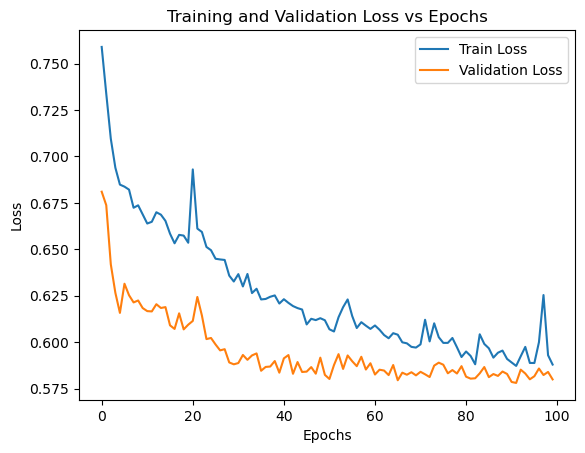

In [11]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### calculate reconstruction loss
calculate MSE for each sample: average squared difference between each feature in the input and its reconstruction

In [12]:
## for training set
X_train_reconstructed = autoencoder_1.predict(X_train)
reconstruction_loss_train = mean_squared_error(X_train, X_train_reconstructed)
print(f"MSE reconstruction loss for training data: {reconstruction_loss_train}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE reconstruction loss for training data: 0.5700693399470806


In [13]:
## for testing set
X_test_reconstructed = autoencoder_1.predict(X_test)
reconstruction_loss_test = mean_squared_error(X_test, X_test_reconstructed)
print(f"MSE reconstruction loss for testing data: {reconstruction_loss_test}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MSE reconstruction loss for testing data: 0.5799289610681908


In [14]:
## for whole set
X_reconstructed = autoencoder_1.predict(sc_data)
reconstruction_loss = mean_squared_error(sc_data, X_reconstructed)
print(f"MSE reconstruction loss for whole data: {reconstruction_loss}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MSE reconstruction loss for whole data: 0.5720412641284484


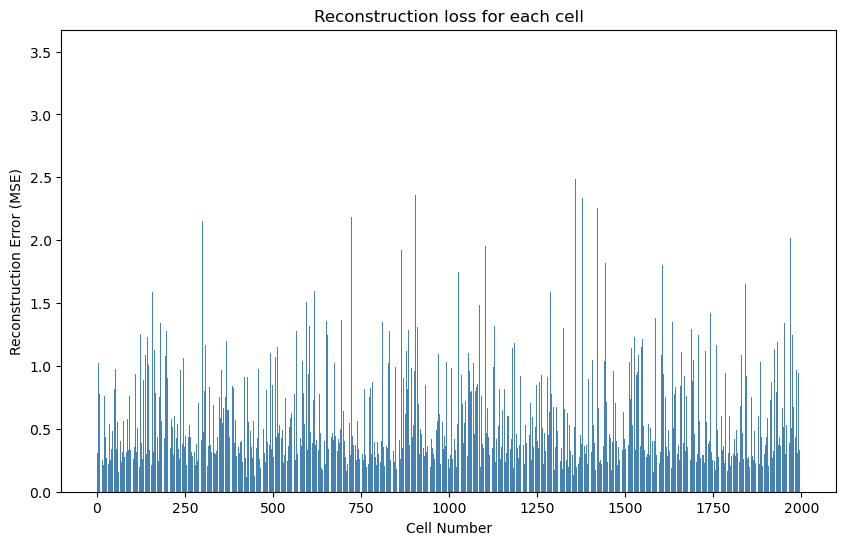

In [15]:
# reconstruction loss for each cell
cell_reconstruction_loss = np.mean(np.square(sc_data - X_reconstructed), axis=1)

plt.figure(figsize=(10, 6))
plt.bar(range(len(cell_reconstruction_loss)), cell_reconstruction_loss, color="steelblue")
plt.title("Reconstruction loss for each cell")
plt.xlabel("Cell Number")
plt.ylabel("Reconstruction Error (MSE)")
plt.show()

#### Extract latent layer

In [16]:
# Define the encoder model to extract the latent space
encoder = keras.Model(inputs=autoencoder_1.input, outputs=autoencoder_1.get_layer('latent').output)

# Predict the latent representation
latent_representation = encoder.predict(sc_data)

# Convert the latent representation to a DataFrame
latent_df = pd.DataFrame(latent_representation, columns=[f"Latent_{i}" for i in range(1, 51)])

print(latent_df)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
      Latent_1  Latent_2  Latent_3  Latent_4  Latent_5  Latent_6  Latent_7  \
0          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4          0.0       0.0       0.0       0.0       0.0       0.0       0.0   
...        ...       ...       ...       ...       ...       ...       ...   
1995       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1996       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1997       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1998       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1999       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

      Latent_8  Latent_9

## PCA visualization on the latent layer

In [17]:
# PCA model
pca_auto_model = PCA(n_components=50, random_state=42)
pca_auto_out = pca_auto_model.fit_transform(latent_df)

In [18]:
# analyze explained variance: see how much info is retained with each added component
pca_auto_var = pca_auto_model.explained_variance_ratio_
#print(pca_auto_var)

cum_auto_var = pca_auto_var.cumsum()
print(cum_auto_var)

pc_needed = np.argmax(cum_auto_var >= 0.80)
print(f"{pc_needed} components are needed to explain at least 80% of the variance")


# Percentage of variance explained by each component
explained_variance_ratio = pca_auto_var * 100
# Display results
for i, variance in enumerate(explained_variance_ratio, start=1):
    print(f"PC{i}: {variance:.2f}% of variance explained")

[0.30566686 0.53370863 0.65692985 0.7664002  0.8280511  0.8801426
 0.9135408  0.9313     0.9478088  0.96273106 0.9763325  0.98738444
 0.9959963  0.9998943  0.9999421  0.9999821  0.9999988  0.99999994
 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
 0.99999994 0.99999994]
4 components are needed to explain at least 80% of the variance
PC1: 30.57% of variance explained
PC2: 22.80% of variance explained
PC3: 12.32% of variance explained
PC4: 10.95% of variance explained
PC5: 6.17% of variance explained
PC6: 5.21% of variance explained
PC7: 3.34% of variance explained
PC8: 1.78% of variance explained
PC9: 1.65% of variance explained
PC10: 1.49% of variance explained
PC11: 1.36% of variance explained
PC12: 1.

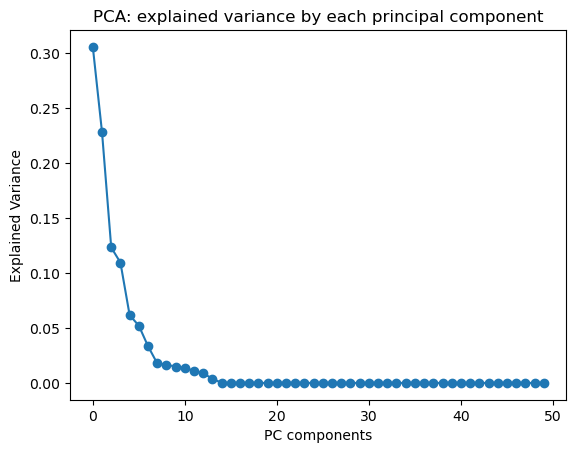

In [19]:
# plot: explained variance by each principal component 
plt.plot(pca_auto_var, marker='o')
plt.title("PCA: explained variance by each principal component")
plt.xlabel("PC components")
plt.ylabel("Explained Variance")
plt.show()

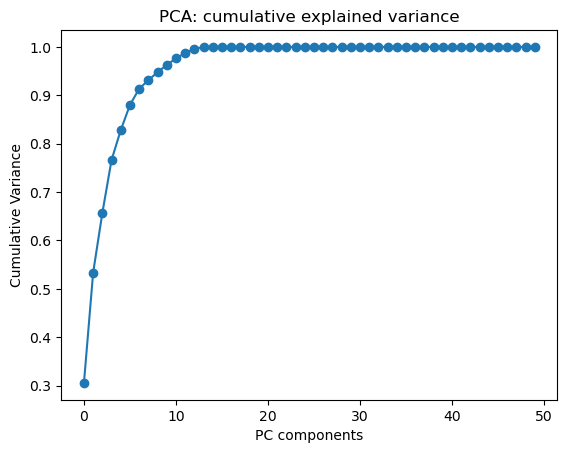

In [20]:
# plot: cumulative variance by each principal component 
plt.plot(cum_auto_var, marker='o')
plt.title("PCA: cumulative explained variance")
plt.xlabel("PC components")
plt.ylabel("Cumulative Variance")
plt.show()

In [21]:
# add true label to visualize PCA
#print(pca_out, pca_out.shape)

# convert to pd dataframe
pca_auto_df = pd.DataFrame(pca_auto_out, columns=[f"PC{i}" for i in range(1,51)])
#print(pca_df)

labels_list = (label_data["Cluster"]).tolist()
print(len(labels_list))

pca_auto_df["Labels"] = labels_list
pca_auto_df["Labels"] = pca_auto_df["Labels"].astype(str)
print(pca_auto_df)

2000
            PC1        PC2       PC3       PC4       PC5        PC6       PC7  \
0     17.069977 -25.566805  1.701123 -3.837700 -7.184939  -7.494225  0.469315   
1     -3.239825   0.273520 -1.490267 -1.543452 -0.122410   0.548369 -0.127382   
2     -3.017290   0.602044 -1.279296 -1.650703  0.117217   0.852255 -0.060803   
3     -2.917282   0.012870 -1.883666 -1.062932 -0.926552  -0.211576 -0.111123   
4     -3.124171   0.180049 -1.631211 -1.371078 -0.410769   0.275859 -0.121494   
...         ...        ...       ...       ...       ...        ...       ...   
1995  -2.792086   0.633467 -0.994800 -1.177622 -0.221273   0.519963  0.427656   
1996  -2.911260   0.007924 -1.890758 -1.053569 -0.941889  -0.226069 -0.110624   
1997  -3.246283   0.278774 -1.482351 -1.553150 -0.106191   0.563706 -0.127713   
1998  50.332451  39.956356  1.978947 -0.024364 -3.100048  11.480390  0.393440   
1999  -3.313370   0.455543 -1.187964 -1.735831  0.483895   0.675154 -0.055650   

           PC8       P

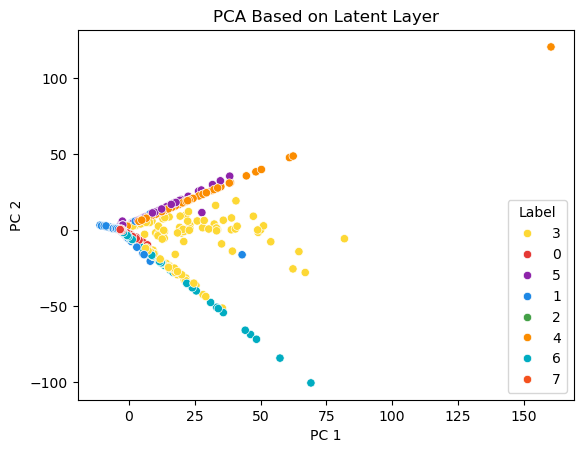

In [22]:
custom_palette = {
    "0": "#E53935",  # Crimson
    "1": "#1E88E5",  # Royal Blue
    "2": "#43A047",  # Forest Green
    "3": "#FDD835",  # Golden Yellow
    "4": "#FB8C00",  # Bright Orange
    "5": "#8E24AA",  # Violet
    "6": "#00ACC1",  # Cerulean
    "7": "#F4511E",  # Vermilion
}

sns.scatterplot(data=pca_auto_df, x="PC1", y="PC2", hue="Labels", palette=custom_palette)
plt.title("PCA Based on Latent Layer")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title="Label")
plt.show()

random forest/svm quantify how separable
clustering 
train a classifier 
* latent vs topc 50 PCA
* if latent classify better, learn more 

Visualize in 3d plot

compare autoencoder and pca

#### evaluation

In [23]:
pca_auto_2d = pca_auto_df[['PC1', 'PC2']]
print(pca_auto_2d)

# silhouette_score score
pca_auto_sil = silhouette_score(pca_auto_2d, label_data["Cluster"])
print(f"silhouette score for 2D PCA projection: {pca_auto_sil}")

            PC1        PC2
0     17.069977 -25.566805
1     -3.239825   0.273520
2     -3.017290   0.602044
3     -2.917282   0.012870
4     -3.124171   0.180049
...         ...        ...
1995  -2.792086   0.633467
1996  -2.911260   0.007924
1997  -3.246283   0.278774
1998  50.332451  39.956356
1999  -3.313370   0.455543

[2000 rows x 2 columns]
silhouette score for 2D PCA projection: -0.15831820666790009


## UMAP based on the latent layer

start analysis for UMAP transformation n_neighbors = 5 and min_dist = 0.1


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 5 and min_dist = 0.1 is: 4.4579901695251465


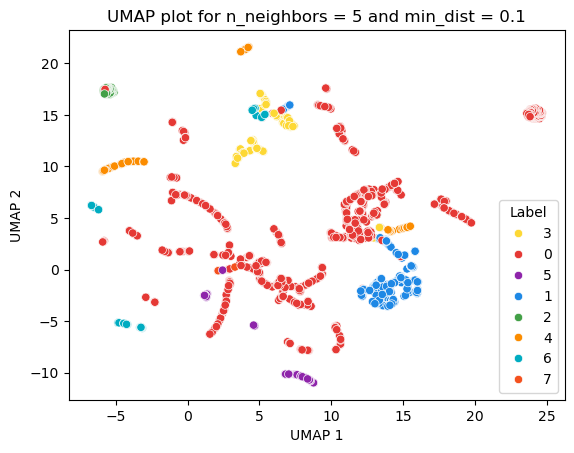

silhouette score for n_neighbors = 5 and min_dist = 0.1: -0.06344634294509888


start analysis for UMAP transformation n_neighbors = 5 and min_dist = 0.5


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 5 and min_dist = 0.5 is: 2.746062994003296


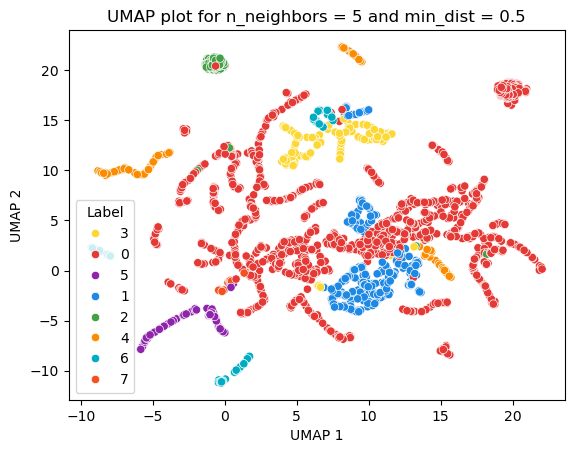

silhouette score for n_neighbors = 5 and min_dist = 0.5: -0.0973660871386528


start analysis for UMAP transformation n_neighbors = 5 and min_dist = 0.9


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 5 and min_dist = 0.9 is: 2.758577823638916


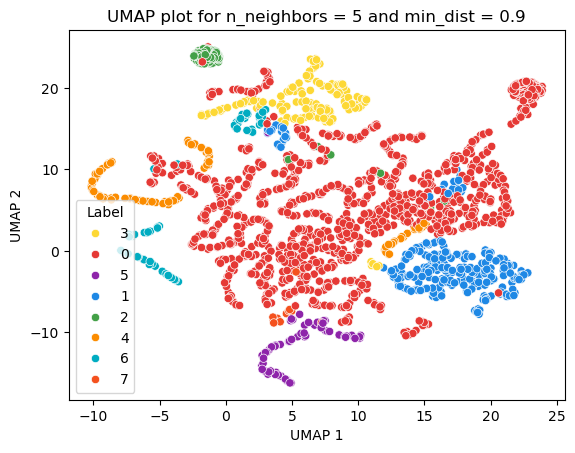

silhouette score for n_neighbors = 5 and min_dist = 0.9: -0.02435077540576458


start analysis for UMAP transformation n_neighbors = 15 and min_dist = 0.1


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 15 and min_dist = 0.1 is: 4.40014386177063


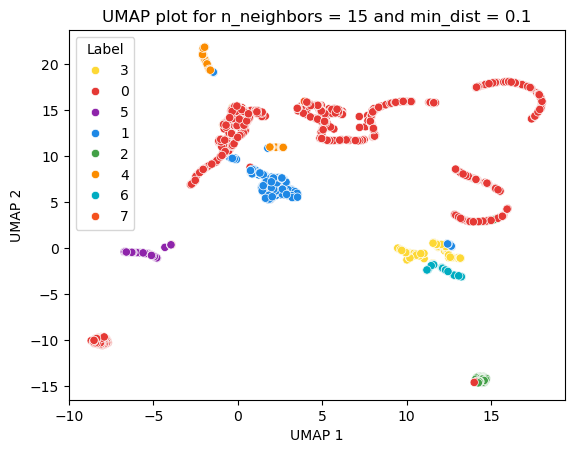

silhouette score for n_neighbors = 15 and min_dist = 0.1: -0.023753203451633453


start analysis for UMAP transformation n_neighbors = 15 and min_dist = 0.5


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 15 and min_dist = 0.5 is: 4.485821008682251


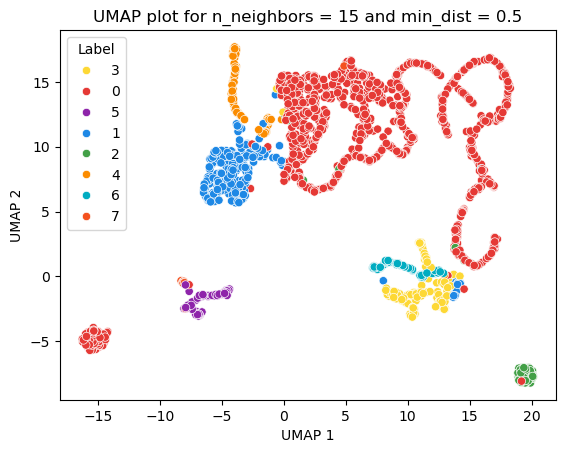

silhouette score for n_neighbors = 15 and min_dist = 0.5: -0.04435687139630318


start analysis for UMAP transformation n_neighbors = 15 and min_dist = 0.9


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 15 and min_dist = 0.9 is: 4.653916835784912


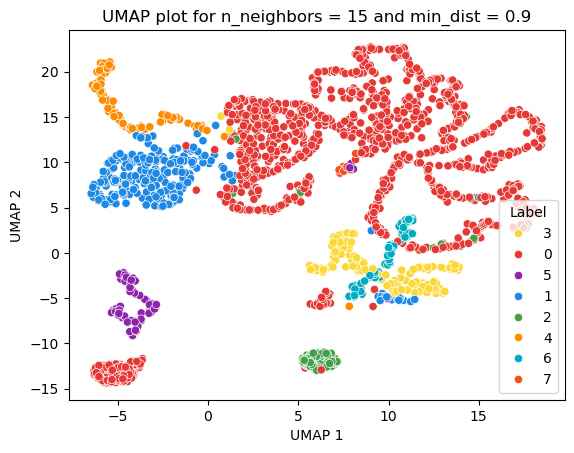

silhouette score for n_neighbors = 15 and min_dist = 0.9: -0.1516273468732834


start analysis for UMAP transformation n_neighbors = 30 and min_dist = 0.1


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 30 and min_dist = 0.1 is: 6.065655708312988


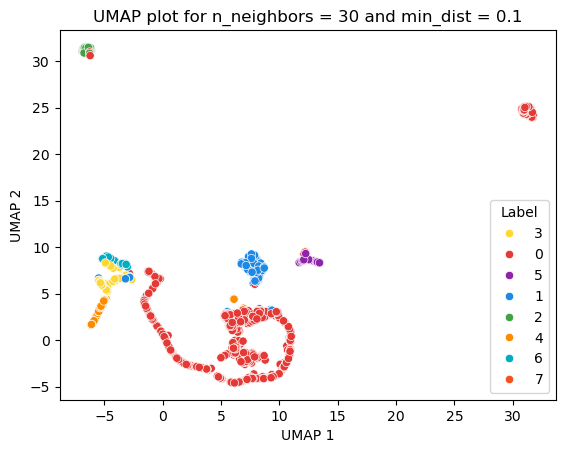

silhouette score for n_neighbors = 30 and min_dist = 0.1: -0.0010825040517374873


start analysis for UMAP transformation n_neighbors = 30 and min_dist = 0.5


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 30 and min_dist = 0.5 is: 6.0630998611450195


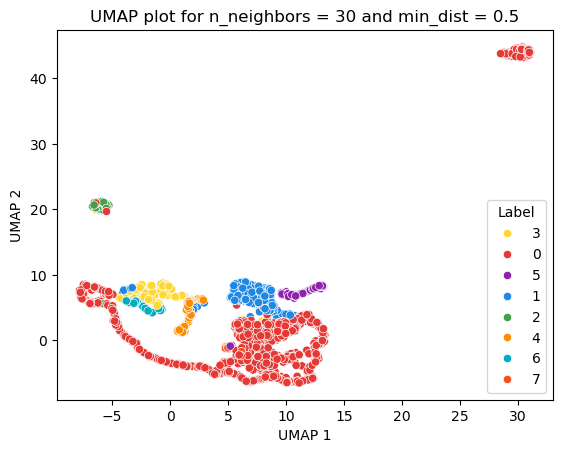

silhouette score for n_neighbors = 30 and min_dist = 0.5: -0.18193411827087402


start analysis for UMAP transformation n_neighbors = 30 and min_dist = 0.9


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


umap duration for n_neighbors = 30 and min_dist = 0.9 is: 6.139203071594238


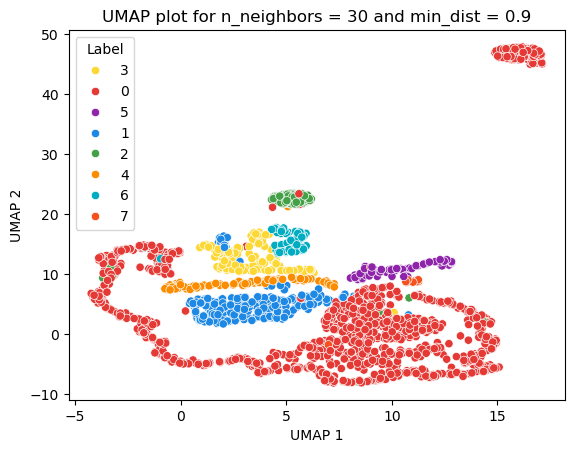

silhouette score for n_neighbors = 30 and min_dist = 0.9: -0.14859411120414734




In [24]:
n_neighbors = [5, 15, 30]
min_dist = [0.1, 0.5, 0.9]

for n in n_neighbors:
    for m in min_dist:
        
        print(f"start analysis for UMAP transformation n_neighbors = {n} and min_dist = {m}")
        
        # record start time
        start_umap = time.time()
        #print(f"start time for n_neighbors = {n} and min_dist = {m} is: {start_umap}")

        # apply umap model
        umap_model = umap.UMAP(n_neighbors=n, min_dist=m, n_components=2, random_state=42, metric='euclidean')
        umap_out = umap_model.fit_transform(latent_df)

        # record end time
        end_umap = time.time()
        #print(f"end time is: {end_umap}")
        
        duration_umap = end_umap - start_umap
        print(f"umap duration for n_neighbors = {n} and min_dist = {m} is: {duration_umap}")

        # convert end_umap to panda df
        #print(umap_out, umap_out.shape)
        umap_df = pd.DataFrame(umap_out, columns=[f"PC{i}" for i in range(1,3)])
        #print(umap_df)

        
        umap_df["Labels"] = labels_list
        umap_df["Labels"] = umap_df["Labels"].astype(str)
        #print(umap_df)
        
        # visualize first two pc components
        sns.scatterplot(data=umap_df, x="PC1", y="PC2", hue="Labels", palette=custom_palette)
        plt.title(f"UMAP plot for n_neighbors = {n} and min_dist = {m}")
        plt.xlabel("UMAP 1")
        plt.ylabel("UMAP 2")
        plt.legend(title="Label")
        plt.show()
        
        # silhouette score
        ## umap_out is a numpy array
        umap_sil = silhouette_score(umap_out, label_data["Cluster"])
        print(f"silhouette score for n_neighbors = {n} and min_dist = {m}: {umap_sil}")
        print('\n')


## hierarchical clustering based on autoencoder

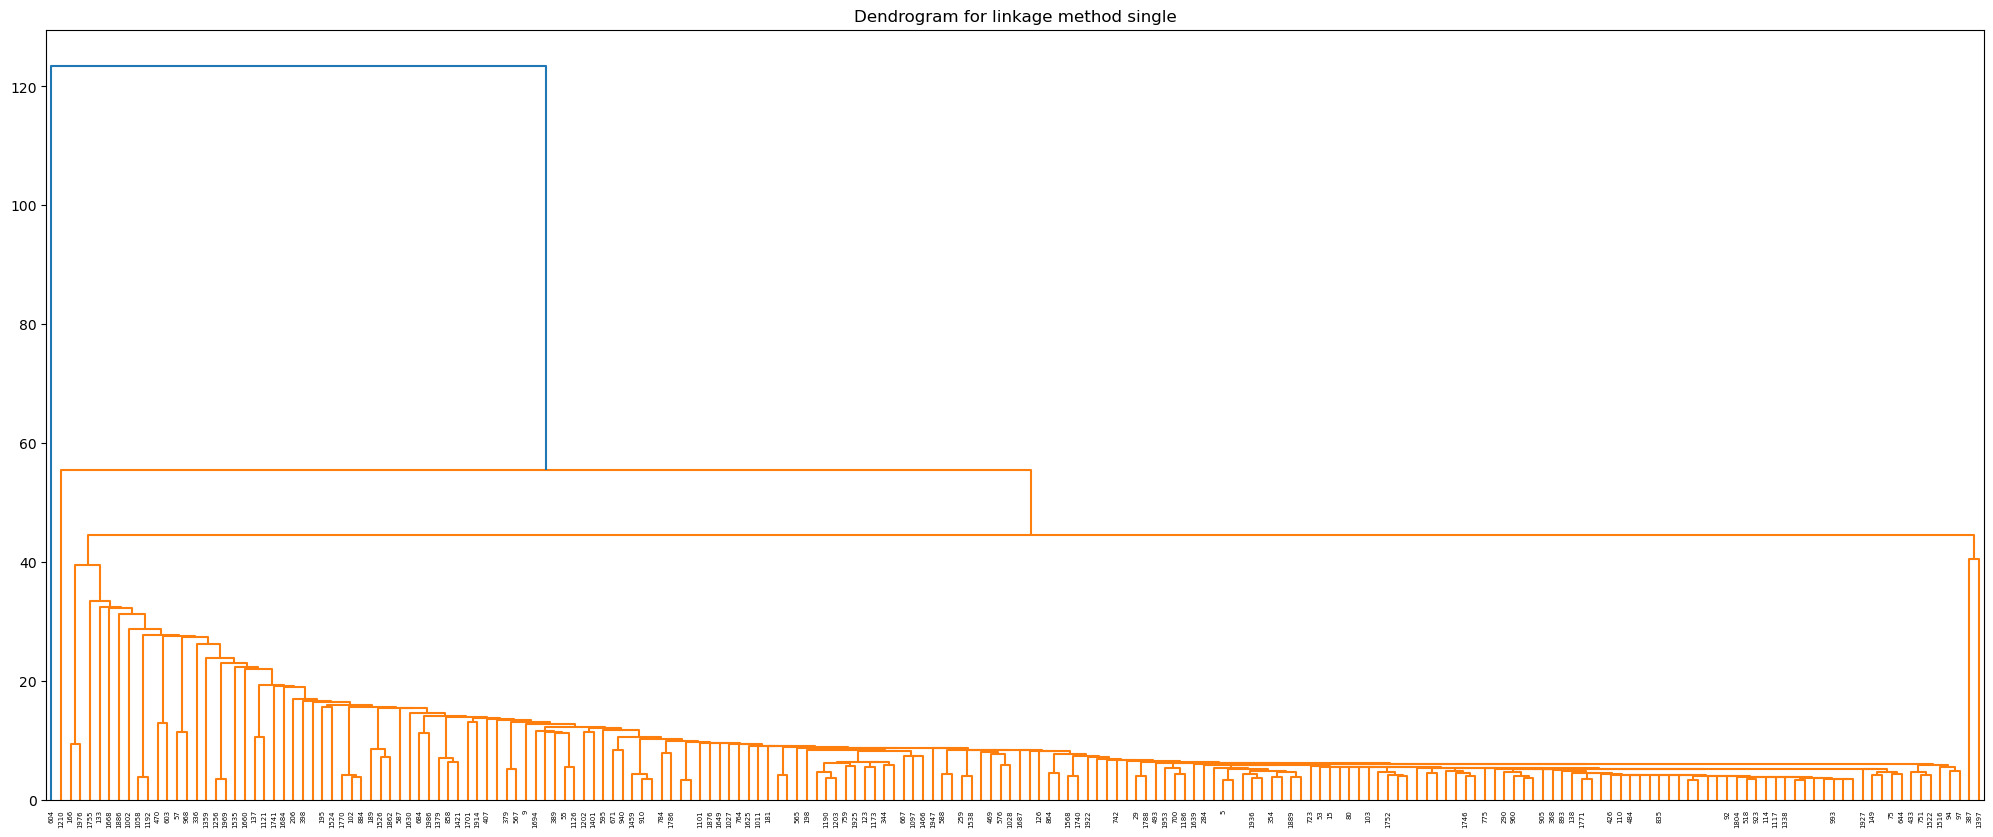

Clusters for linkage method single: [2 2 2 ... 2 2 2]


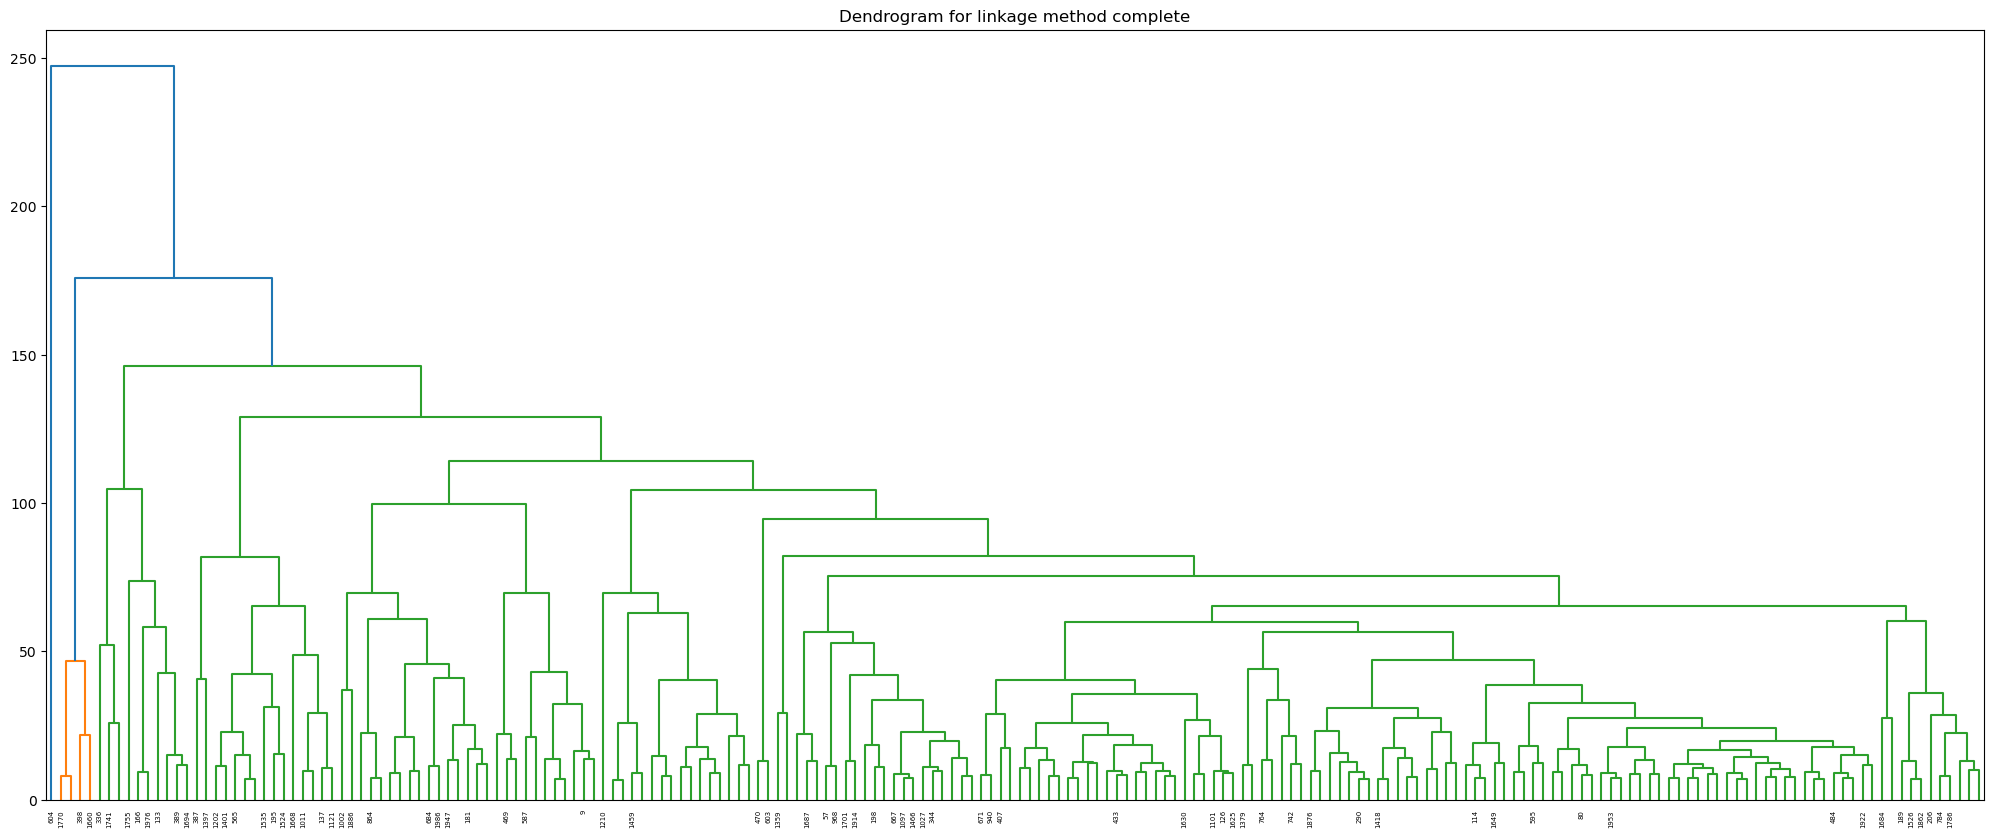

Clusters for linkage method complete: [6 7 7 ... 7 5 7]


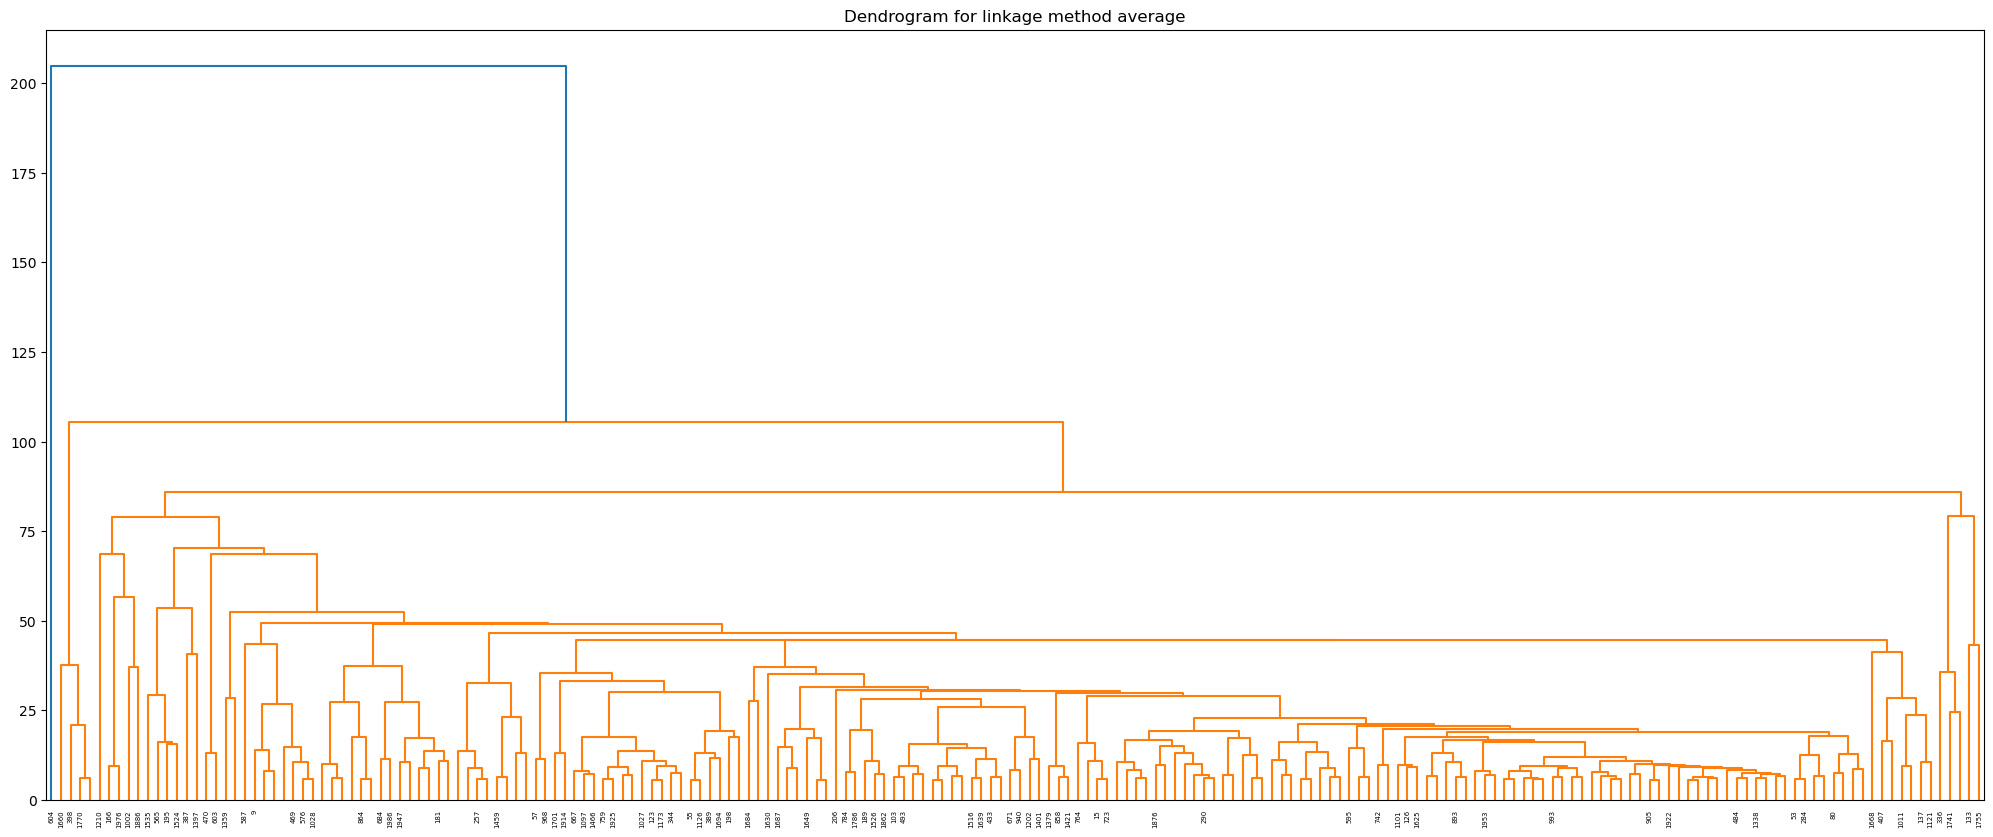

Clusters for linkage method average: [4 4 4 ... 4 4 4]


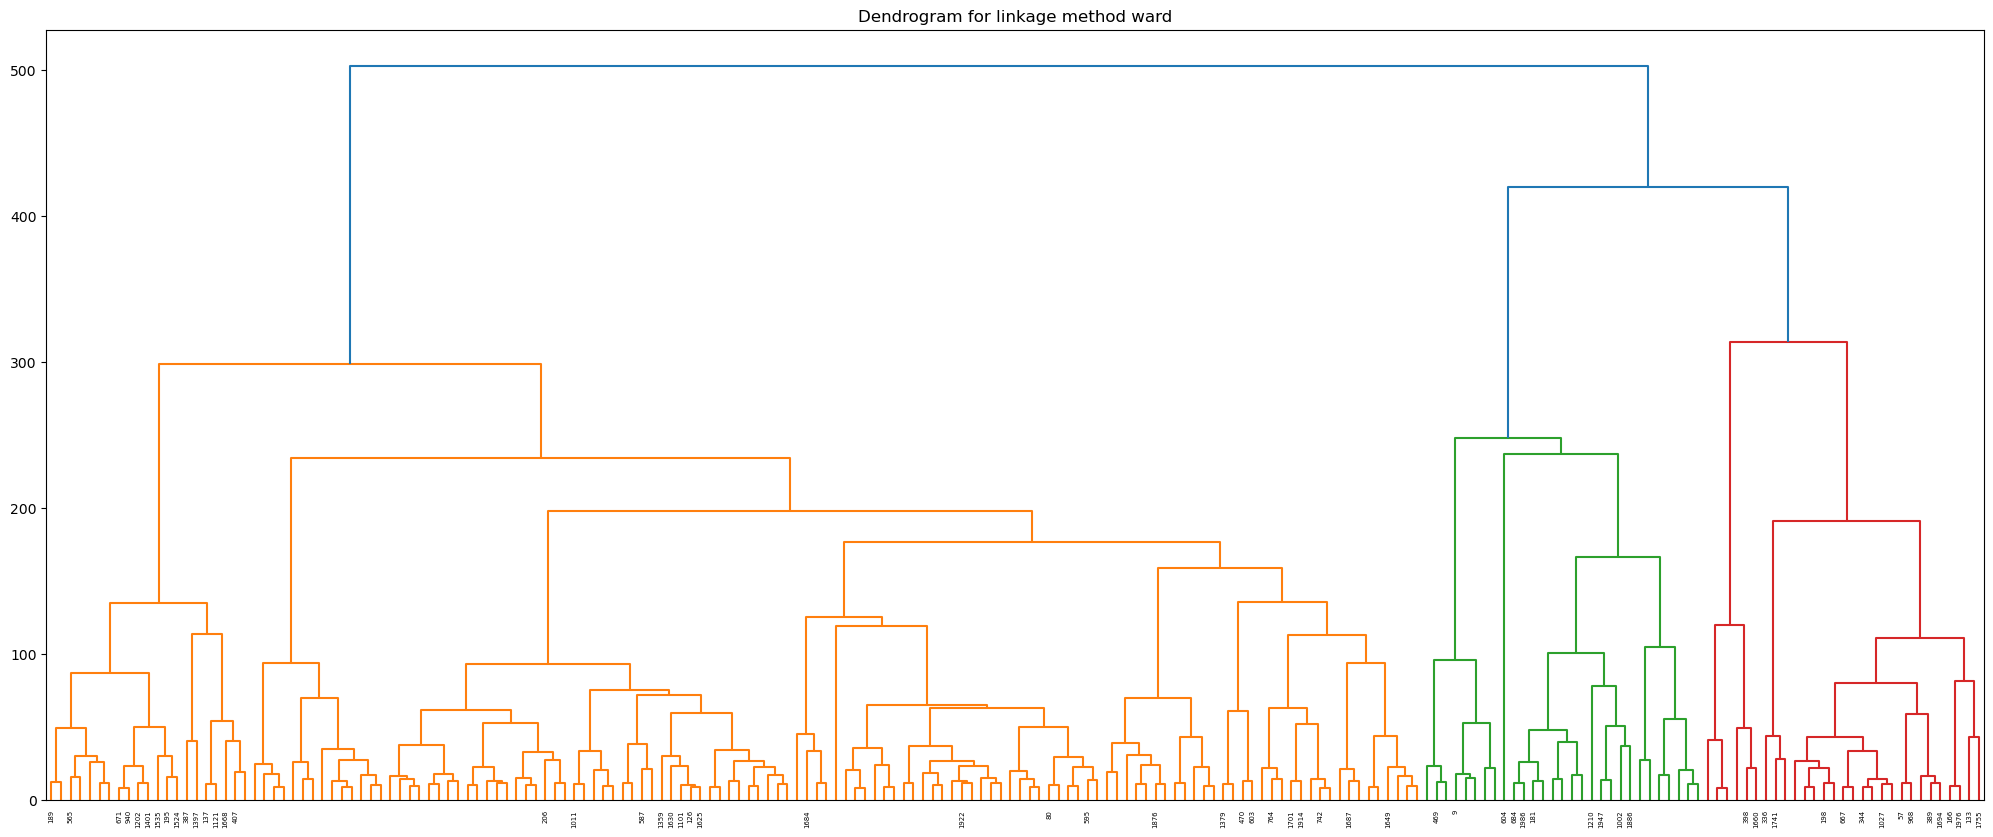

Clusters for linkage method ward: [2 3 3 ... 3 5 3]


In [25]:
linkages = ['single','complete', 'average', 'ward']


for l in linkages:
    hier_model = linkage(latent_df, method=l)
    fig = plt.figure(figsize=(25, 10))
    dn = dendrogram(hier_model, truncate_mode='lastp', p=200, show_leaf_counts=False)
    plt.title(f"Dendrogram for linkage method {l}")
    plt.show()
    

    # cut the dendrogram
    if l == 'single':
        single_clusters = fcluster(hier_model, t=30, criterion='distance')
        print(f"Clusters for linkage method {l}:", single_clusters)
    elif l == 'complete':
        complete_clusters = fcluster(hier_model, t=100, criterion='distance')
        print(f"Clusters for linkage method {l}:", complete_clusters)
    elif l == 'average':
        average_clusters = fcluster(hier_model, t=70, criterion='distance')
        print(f"Clusters for linkage method {l}:", average_clusters)
    elif l == 'ward':
        ward_clusters = fcluster(hier_model, t=200, criterion='distance')
        print(f"Clusters for linkage method {l}:", ward_clusters)

In [26]:
ARI_single = adjusted_rand_score(label_data["Cluster"], single_clusters)
print(f"ARI for single hierarchical: {ARI_single}")

ARI_complete = adjusted_rand_score(label_data["Cluster"], complete_clusters)
print(f"ARI for complete hierarchical: {ARI_complete}")

ARI_average = adjusted_rand_score(label_data["Cluster"], average_clusters)
print(f"ARI for average hierarchical: {ARI_average}")

ARI_ward = adjusted_rand_score(label_data["Cluster"], ward_clusters)
print(f"ARI for ward hierarchical: {ARI_ward}")

ARI for single hierarchical: 0.010289368372623987
ARI for complete hierarchical: 0.19372395059711592
ARI for average hierarchical: 0.023899312912897434
ARI for ward hierarchical: 0.26828181516492755


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


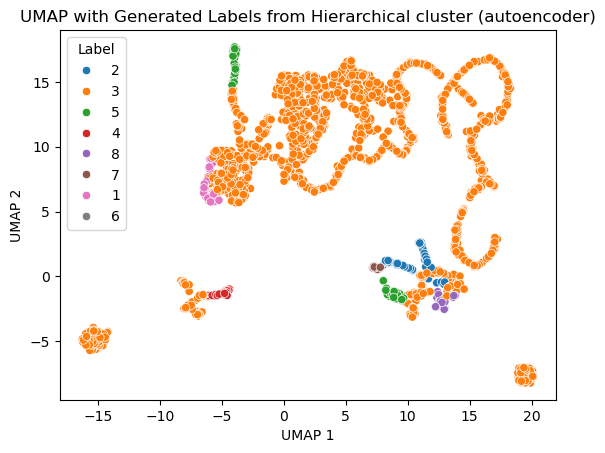

In [27]:
# visualize predicted label
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.5, n_components=2, random_state=42, metric='euclidean')
umap_out = umap_model.fit_transform(latent_df)

# convert end_umap to panda df
#print(umap_out, umap_out.shape)
umap_df = pd.DataFrame(umap_out, columns=[f"PC{i}" for i in range(1,3)])
#print(umap_df)


umap_df["Labels"] = ward_clusters
umap_df["Labels"] = umap_df["Labels"].astype(str)
#print(umap_df)


# visualize first two pc components
sns.scatterplot(data=umap_df, x="PC1", y="PC2", hue="Labels")
plt.title(f"UMAP with Generated Labels from Hierarchical cluster (autoencoder)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Label")
plt.show()

## k means clustering based on autoencoder

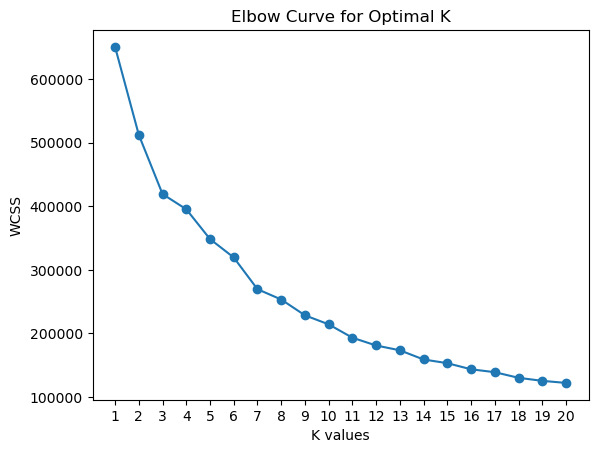

In [35]:
# elbow method determines K
#selected_subset

# list stores wcss
wcss = []

# a range of k values
k_val = range(1,21)

for k in k_val:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(latent_df)
    wcss.append(model.inertia_)

#print(wcss)

# elbow plot
plt.plot(k_val, wcss, marker='o', linestyle='-')
plt.xlabel('K values')
plt.ylabel('WCSS')
plt.xticks(k_val)
plt.title('Elbow Curve for Optimal K')
plt.show()

In [36]:
# k means clustering with k=8
KMeans_model = KMeans(n_clusters=8, random_state=42)
KMeans_model.fit(latent_df)

# predicted clusters
predicted_cluster_auto = KMeans_model.labels_
#print(predicted_cluster, predicted_cluster.shape)

ARI_kmeans_auto = adjusted_rand_score(label_data["Cluster"], predicted_cluster_auto)
print(ARI_kmeans_auto)

0.33322039620812416


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


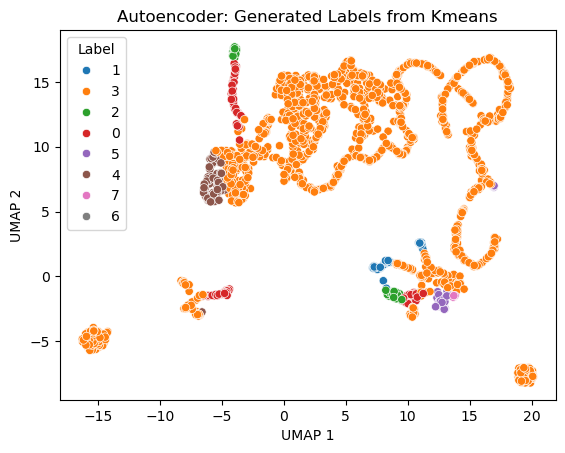

In [37]:
# apply umap model
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.5, n_components=2, random_state=42, metric='euclidean')
umap_out = umap_model.fit_transform(latent_df)

# convert end_umap to panda df
#print(umap_out, umap_out.shape)
umap_df = pd.DataFrame(umap_out, columns=[f"PC{i}" for i in range(1,3)])
#print(umap_df)


umap_df["Labels"] = predicted_cluster_auto
umap_df["Labels"] = umap_df["Labels"].astype(str)
#print(umap_df)


# visualize first two pc components
sns.scatterplot(data=umap_df, x="PC1", y="PC2", hue="Labels")
plt.title(f"Autoencoder: Generated Labels from Kmeans")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Label")
plt.show()

## GMM clustering based on autoencoder

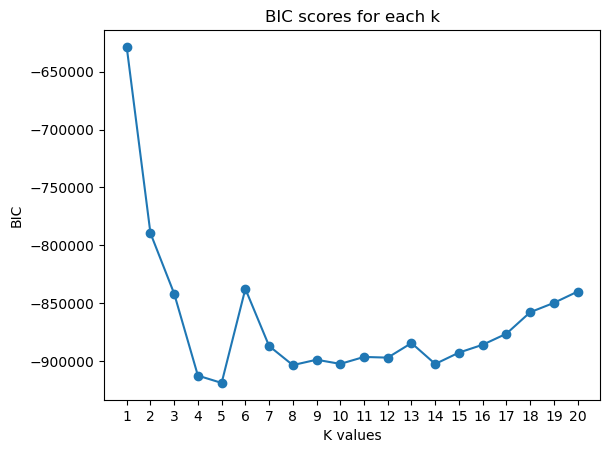

In [31]:
# k values
k_val

# list stores bic score for each k
bic_score = []

for k1 in k_val:
    model_1 = GaussianMixture(n_components=k1, random_state=42)
    model_1.fit(latent_df)
    bic_score.append(model_1.bic(latent_df))

#print(bic_score)

plt.plot(k_val, bic_score, marker='o', linestyle='-')
plt.xlabel('K values')
plt.ylabel('BIC')
plt.xticks(k_val)
plt.title('BIC scores for each k')
plt.show()

In [32]:
# k means clustering with k=8
GMM_model = GaussianMixture(n_components=8, random_state=42)
pred_cluster_GMM = GMM_model.fit_predict(latent_df)

# predicted clusters
print(pred_cluster_GMM)

ARI_GMM_auto = adjusted_rand_score(label_data["Cluster"], pred_cluster_GMM)
print(ARI_GMM_auto)

[1 2 0 ... 2 2 0]
0.15246004353866144


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


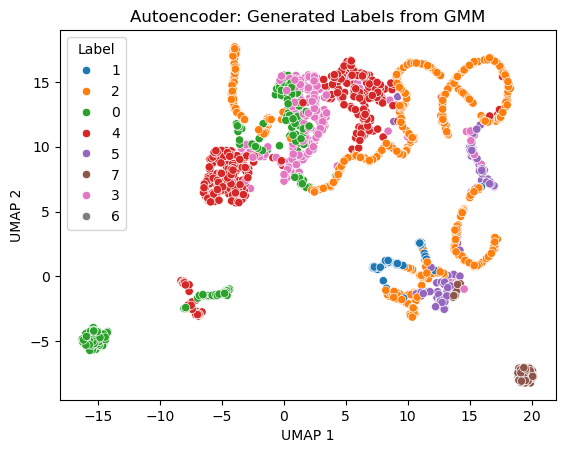

In [33]:
# apply umap model
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.5, n_components=2, random_state=42, metric='euclidean')
umap_out = umap_model.fit_transform(latent_df)

# convert end_umap to panda df
#print(umap_out, umap_out.shape)
umap_df = pd.DataFrame(umap_out, columns=[f"PC{i}" for i in range(1,3)])
#print(umap_df)


umap_df["Labels"] = pred_cluster_GMM
umap_df["Labels"] = umap_df["Labels"].astype(str)
#print(umap_df)


# visualize first two pc components
sns.scatterplot(data=umap_df, x="PC1", y="PC2", hue="Labels")
plt.title(f"Autoencoder: Generated Labels from GMM")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Label")
plt.show()

In [34]:
# silhouette_score score
auto_gmm = silhouette_score(umap_df, pred_cluster_GMM)
print(f"silhouette score for 2D PCA projection: {auto_gmm}")

silhouette score for 2D PCA projection: 0.060677271395920246
